# Lab 1 Report

# Imports and General Functions

In [64]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import ipywidgets as widgets

def zeros(n, dtype=int):
    return [dtype(0.0)] * n

def my_avg(x, dtype=float):
    tot = float(0)
    for i in x:
        tot += i

    m =  tot/len(x)
    return m

def my_std(x, dtype=float): # take an empty array and spit out an array with the mean counts of one image of each exposure time
    m = my_avg(x)
    tot = float(0)
    for i in x:
        tot += (i-m)**2

    return (tot/len(x))**0.5

def ascend_str(ls, idxs):
    idx = 0
    idx_slice = slice(idxs[0], idxs[1])  # make slice for desired indices
    while idx < len(ls):
        for i, x in enumerate(ls):
            if i > idx and int(x[idx_slice]) < int(ls[idx][idx_slice]):  # check for lowest integer at given indices
                ls[i], ls[idx] = ls[idx], x

        idx += 1
    return None

def get_exp(x):
    with fits.open(x) as hdu:
        hdr = hdu[0].header
    return hdr['EXPTIME']

def set_negatives_to_zero_nd(tensor):
    """
    sets negative values to 0 inplace for a rank n tensor
    """
    # check for rank 1
    ele = tensor[0]
    if isinstance(ele, np.ndarray):
        # not inside rank 1 yet so recursively loop with self call
        for sub in tensor:
            set_negatives_to_zero_nd(sub)
    else:
        # we are inside the rank 1 now
        for i, val in enumerate(tensor):
            if val < 0:                         # if less than zero
                tensor[i] = 0                   # set to zero
    return None

# Master Bias Frame

In [62]:
bias_frames = glob.glob('Lab1_data/d20[0-1][0-9].fits')

def bias(x):
    n = len(x)
    tot = zeros(n, dtype=float)

    for i, file in enumerate(x):
        arr = fits.getdata(file)
        tot[i] = arr
    avg = my_avg(tot)
    return avg

biasdat = bias(bias_frames)


# Bias Subtraction

In [61]:
def bias_sub(x):
    n = len(x)
    tot = zeros(n, dtype=float)

    for i, file in enumerate(x):
        arr = fits.getdata(file)
        tot[i] = arr - biasdat
    return tot

frames = glob.glob('Lab1_data/d20[4-8][0-9].fits')
ascend_str(frames, (-7,-5))
allframes = bias_sub(frames)

set_negatives_to_zero_nd(allframes)
np.min(allframes)

np.float64(0.0)

# ImShow

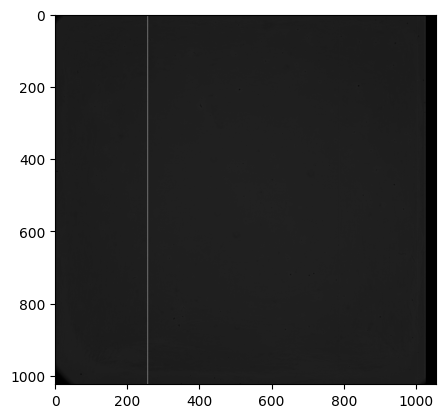

In [74]:
np.shape(allframes)
plt.imshow(fits.getdata(frames[20]), cmap='grey')
plt.show()

# Exposure Frames

In [5]:
def exp_frames(x):
    tot = []
    for i in range(0,len(x),5):
        tot.append(x[i])
    return tot

exp_frames = exp_frames(allframes)


list

# Histograms

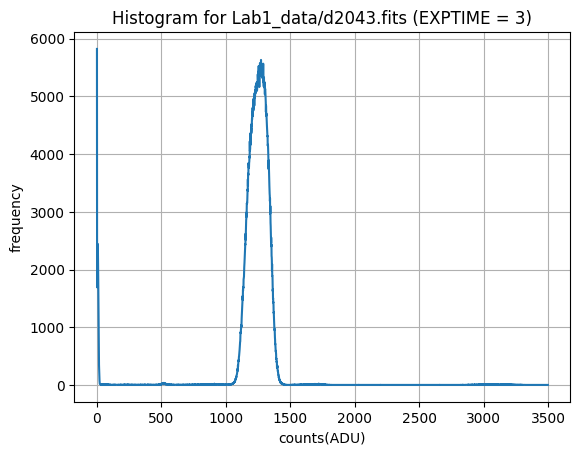

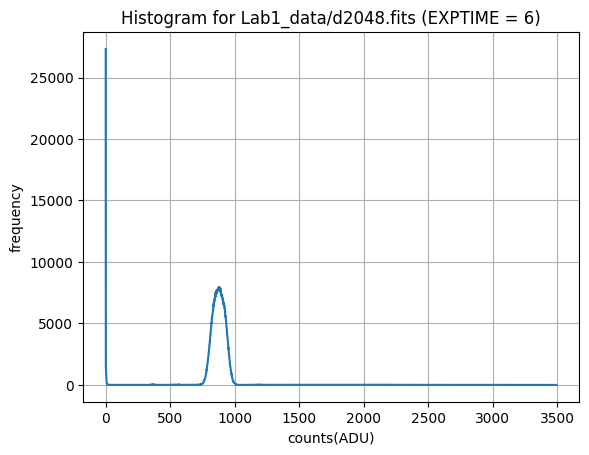

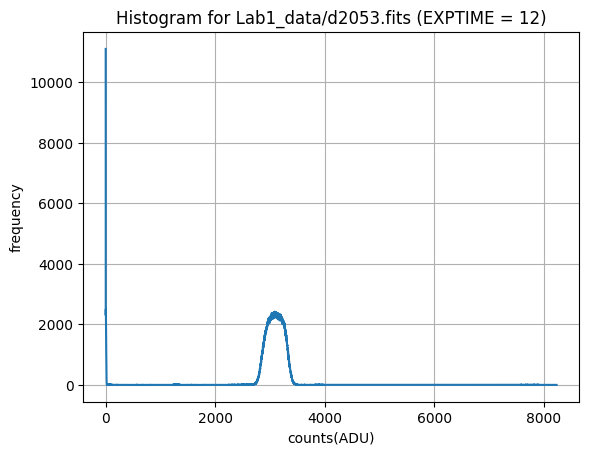

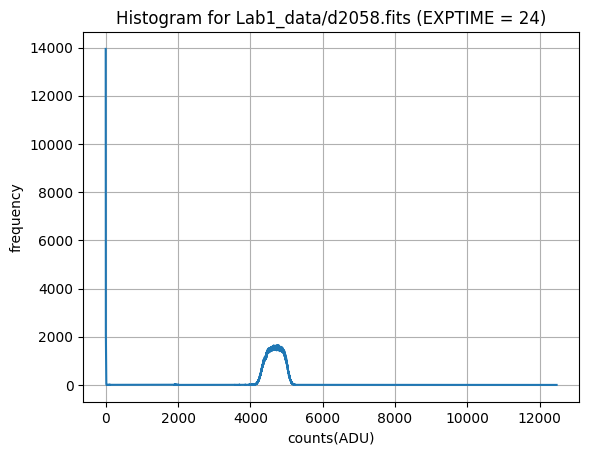

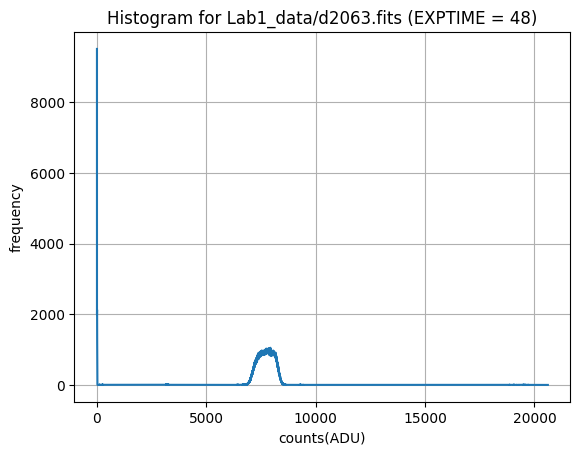

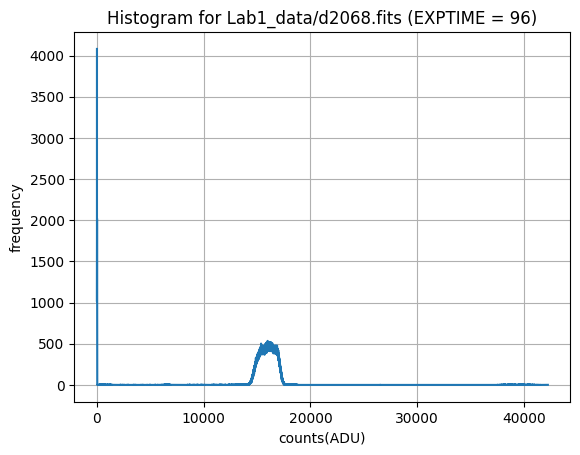

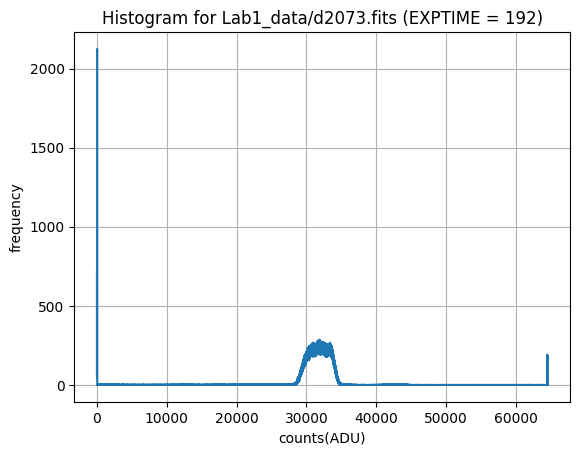

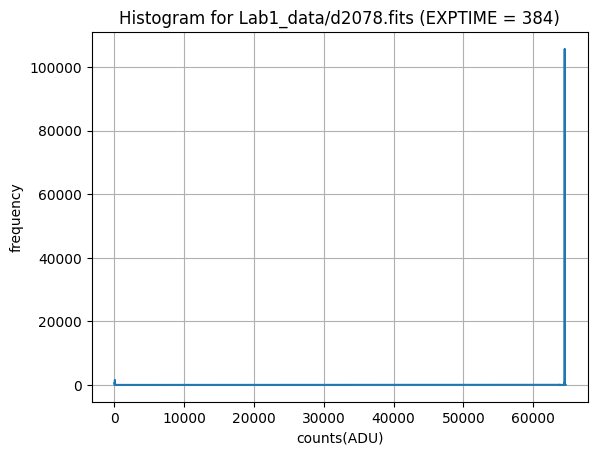

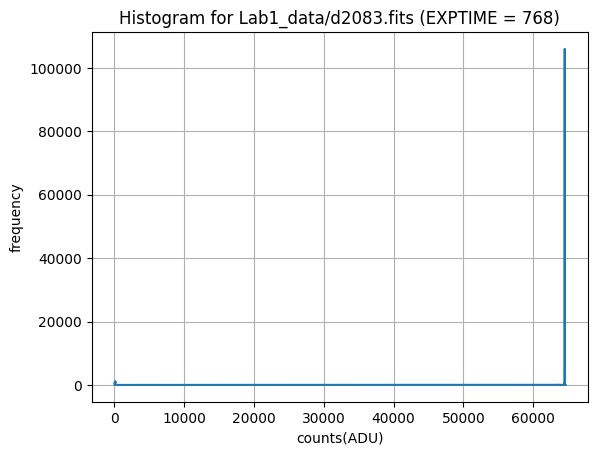

In [45]:
def histogram(file): # Function for creating a histogram of the desired filename

    farr = file.flatten()

    hmin = int(round(farr.min(), 0))
    hmax = int(round(farr.max(), 0))
    #hmax = int(farr.max())

    # initialize bins and empty count x[i]
    hr = np.arange(hmin, hmax + 1)
    hist = zeros(hmax - hmin + 1, dtype=int)

    # count each value in bins
    for value in farr:
        if hmin <= value <= hmax:
            hist[int(value - hmin)] += 1

    return hr, hist




for i, data in enumerate(exp_frames):

    idx = int(i*5)
    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)
    plt.plot(hr, hist)
    plt.xlabel('counts(ADU)')
    plt.ylabel('frequency')
    plt.title(f'Histogram for {frames[idx]} (EXPTIME = {exp_time})')
    plt.grid()
    plt.show()


In [37]:
print(exp_frames[0])

[[ 44.81818182  42.54545455  56.09090909 ...   8.27272727   0.
   13.        ]
 [135.09090909  81.27272727  79.90909091 ...  13.72727273   0.
    3.63636364]
 [166.27272727  77.          77.09090909 ...   7.72727273   9.63636364
   12.09090909]
 ...
 [ 37.72727273  17.09090909  19.45454545 ...   0.           2.
    1.09090909]
 [ 46.63636364  20.45454545  11.         ...   0.           0.
    9.54545455]
 [ 50.45454545  15.72727273   1.45454545 ...   0.           0.
    0.        ]]


# Mean

In [21]:
for data in exp_frames:
    print(my_avg(data.flatten()))

1213.54258395951
850.7603714367333
3000.4999873053794
4538.5804702295545
7488.739279418763
15494.145201122927
30795.93051147559
62366.44977302471
62411.71480061998


# Standard Deviation

In [23]:
for data in exp_frames:
    print(my_std(data.flatten()))

243.63819202177527
172.07854891273178
600.8876795432038
908.6361523537043
1496.6312775139857
3094.7707389025027
5993.12972541988
11413.106452399581
11335.79637682977


# Mean vs. Standard Deviation Plot

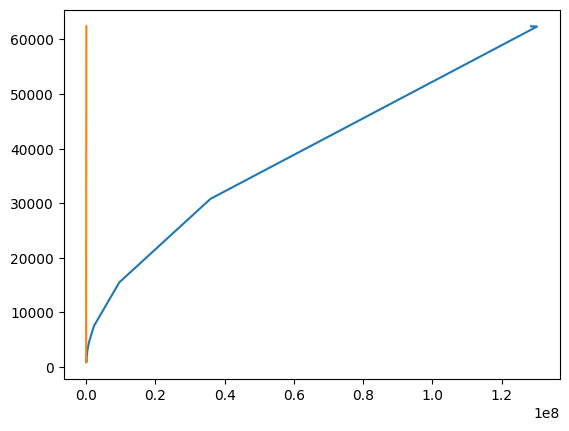

In [24]:
avg = zeros(len(exp_frames), dtype=float)
dev = zeros(len(exp_frames), dtype=float)


for i,data in enumerate(exp_frames):
    avg[i] = my_avg(data.flatten())
    dev[i] = my_std(data.flatten())

devsqr = list(map(lambda x: x**2, dev))

fig, ax = plt.subplots()

ax.plot(devsqr,avg)
ax.plot(avg,avg)
plt.show()

# Log Log Plot

In [20]:
print(dev)

[np.float64(243.63819202177527), np.float64(172.07854891273178), np.float64(600.8876795432038), np.float64(908.6361523537043), np.float64(1496.6312775139857), np.float64(3094.7707389025027), np.float64(5993.12972541988), np.float64(11413.106452399581), np.float64(11335.79637682977)]


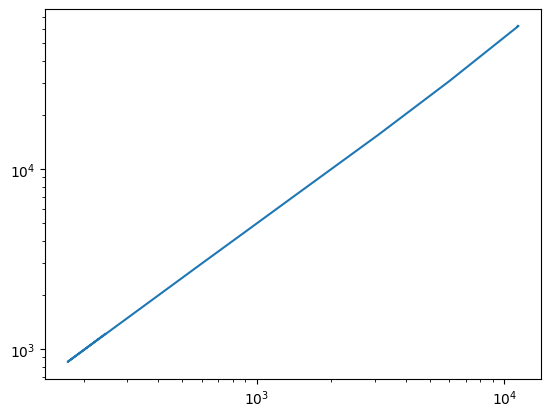

In [25]:
plt.loglog(dev,avg)
plt.show()

# Flat Frame Division

In [11]:
def ffdiv(x,file):
    exp = get_exp(file)
    return x/exp


reduced_flats = zeros(len(allframes), dtype=float)
for i,x in enumerate(allframes):
    reduced_flats[i] = ffdiv(x,frames[i])
np.shape(reduced_flats)
type(reduced_flats)

list

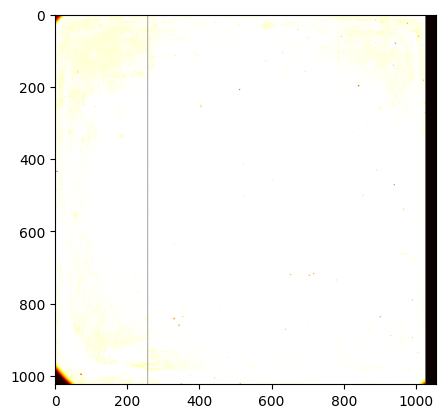

In [12]:
plt.imshow(reduced_flats[-4], cmap='hot')
plt.show()

# MOM & SDOM

In [13]:
n = len(reduced_flats)
means = []
MOMs = zeros(n, dtype=float)
SDOMs = zeros(n, dtype=float)

for i,x in enumerate(reduced_flats):
    fx = x.flatten()
    means.append(my_avg(fx))
    MOM = my_avg(means)
    SDOM = my_std(means)
    MOMs[i] = MOM
    SDOMs[i] = SDOM


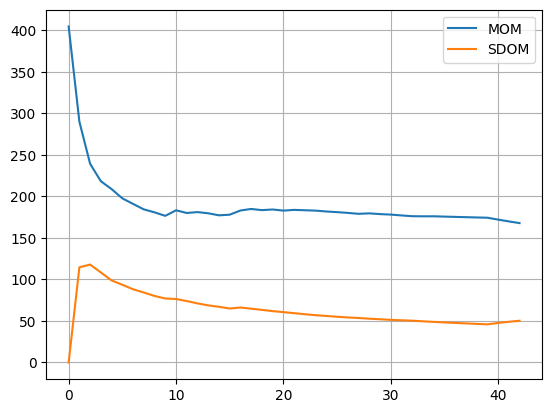

In [14]:
num_frames = np.arange(0,len(allframes))

fig, ax = plt.subplots()
ax.plot(num_frames,MOMs, label='MOM')
ax.plot(num_frames,SDOMs, label='SDOM')
plt.grid()
ax.legend()
plt.show()

# Poisson Distribution

In [15]:
def poisson_log(x, mu):
    """
    Logarithmic approximation of Poisson distribution to avoid overflow error
    :param x: float, x value, must be positive
    :param mu: float, mean of the distribution
    :return: approximate value of the Poisson distribution
    """
    if x==0:
        log = -mu
    else:
        log = x * (math.log(mu) - math.log(x)) + x - mu
    return math.exp(log)

def get_poisson(data, xrange=None):
    fdata = data.flatten()
    mu = my_avg(fdata)
    if xrange is None:
        x_min = int(fdata.min())
        x_max = int(fdata.max())
    else:
        x_min, x_max = xrange

    x_values = np.arange(x_min, x_max + 1)

    p_values = [poisson_log(x, mu) for x in x_values]

    return x_values, p_values

def poisson_plot(file):

    farr = file.flatten()

    hmin = int(farr.min())
    hmax = int(farr.max())

    # initialize bins and empty count x[i]
    hr = np.arange(hmin, hmax + 1)
    hist = np.zeros(hmax - hmin + 1, dtype=int)

    # count each value in bins
    for value in farr:
        if hmin <= value <= hmax:
            hist[int(value - hmin)] += 1

    return hr, hist



    #plt.plot(hr,hist)
    #plt.plot(get_poisson(file))
    #plt.xlim(0,2000)
    #plt.grid(True)
    #plt.xlabel('counts(ADU)')
    #plt.ylabel('frequency')
    #plt.show()


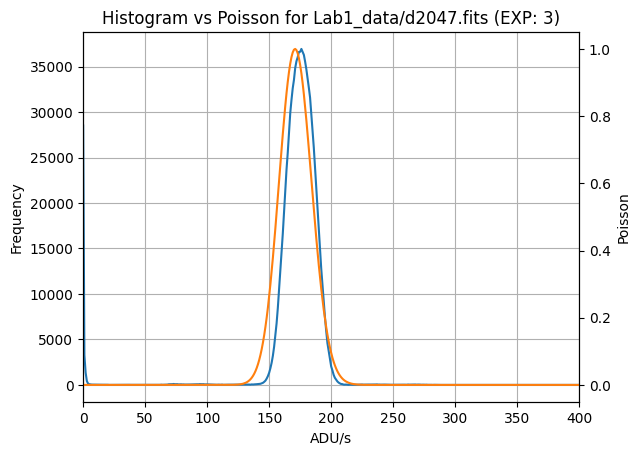

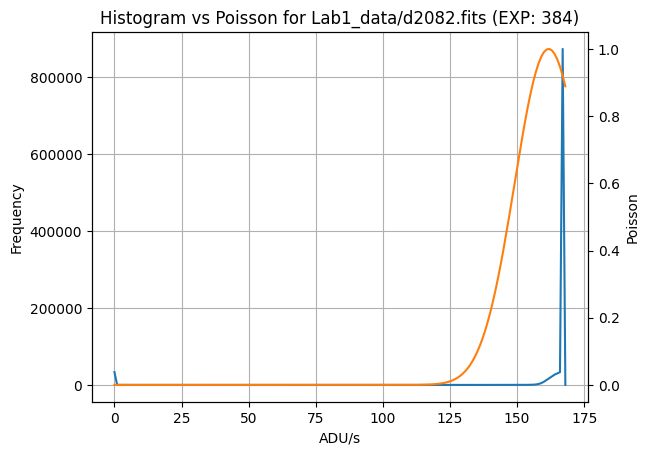

In [16]:
chosen_frames = (reduced_flats[4], reduced_flats[-4])
for i, data in enumerate(chosen_frames):
    idx = int(-8*i + 4)
    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)

    x, p = get_poisson(data)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(hr, hist, label='Histogram', color='tab:blue')
    ax2.plot(x, p, label='Poisson', color='tab:orange')

    if i==0:
        plt.xlim(0, 400)

    ax1.grid()
    ax1.set_xlabel('ADU/s')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Poisson')
    ax.legend()
    plt.title(f'Histogram vs Poisson for {frames[idx]} (EXP: {exp_time})')
    plt.show()


# Mean and Standard Deviation of Poisson fit files

In [18]:
for i,data in enumerate(chosen_frames):
    fdata = data.flatten()
    idx = int(-8*i + 4)
    name = frames[idx]
    exp_time = get_exp(name)
    mean = my_avg(fdata)
    std = my_std(fdata)
    print(f'Frame: {name}, EXP: {exp_time}')
    print(f'Mean: {mean}')
    print(f'STD: {std}')
    print('-------------------------')


Frame: Lab1_data/d2047.fits, EXP: 3
Mean: 170.9042623220421
STD: 34.97446079221624
-------------------------
Frame: Lab1_data/d2082.fits, EXP: 384
Mean: 161.77758872476394
STD: 29.699390118887706
-------------------------


# Gaussian Plots

In [27]:
def gaussian(x, mu, sigma):
    coeff = 1/(sigma * (2*math.pi)**0.5)
    expo = math.exp(-(1/2)*((x - mu)/sigma)**2)
    return coeff * expo

def get_gaussian(data, xrange=None):
    fdata = data.flatten()
    mu = my_avg(fdata)
    sigma = my_std(fdata)
    if xrange is None:
        x_min = int(fdata.min())
        x_max = int(fdata.max())
    else:
        x_min, x_max = xrange

    x_values = np.arange(x_min, x_max + 1)
    g_values = [gaussian(x, mu, sigma) for x in x_values]

    return x_values, g_values

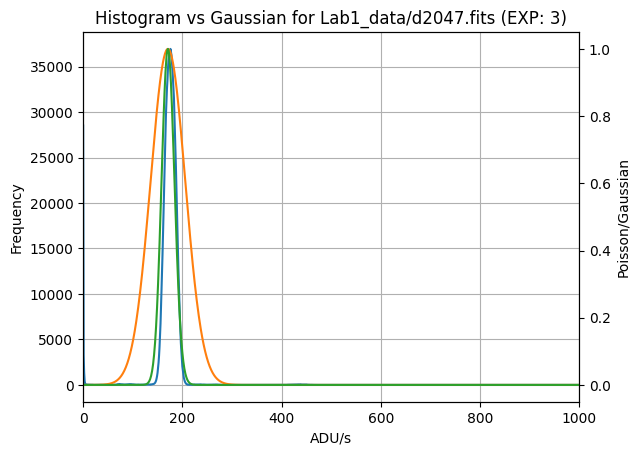

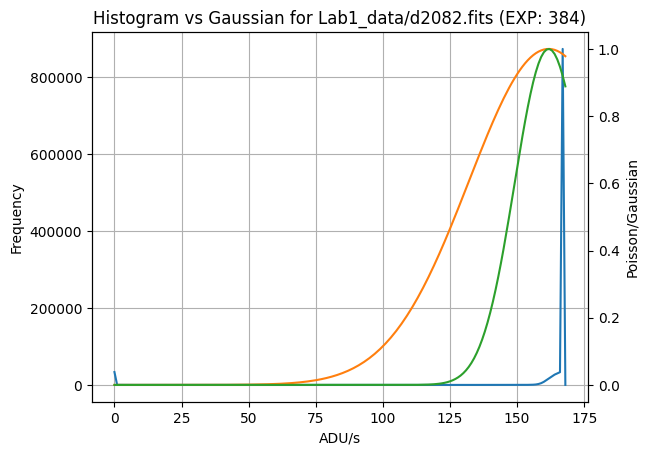

In [29]:
for i, data in enumerate(chosen_frames):
    idx = int(-8*i + 4)

    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)

    x1, g = get_gaussian(data)
    x2, p = get_poisson(data)
    scale_factor = max(g)

    g = [gv/scale_factor for gv in g]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(hr, hist, label='Histogram', color='tab:blue')

    ax2.plot(x1, g, label='Gaussian', color='tab:orange')
    ax2.plot(x2, p, label='Poisson', color='tab:green')

    ax1.set_xlabel('ADU/s')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Poisson/Gaussian')

    if i==0:
        ax1.set_xlim(0, 1000)

    ax1.grid()
    plt.title(f'Histogram vs Gaussian for {frames[idx]} (EXP: {exp_time})')
    plt.show()

# Measuring Detector Readnoise and Gain

In [65]:
frame = allframes[-4]

def display_crop(row, col, window_size):

    crop = frame[row:row+window_size, col:col+window_size]
    plt.imshow(crop, cmap='hot')
    plt.title(f'({row}, {col})')
    plt.show()

win_size = 75
step_size = 5

row_slider = widgets.IntSlider(min=0, max=frame.shape[0]-win_size-1, step=step_size, value=375)
col_slider = widgets.IntSlider(min=0, max=frame.shape[0]-win_size-1, step=step_size, value=375)
win_slider = widgets.IntSlider(min=5, max=200, step=step_size, value=win_size)

widgets.interact(display_crop, row=row_slider, col=col_slider, window_size=win_slider)

interactive(children=(IntSlider(value=375, description='row', max=948, step=5), IntSlider(value=375, descripti…

<function __main__.display_crop(row, col, window_size)>

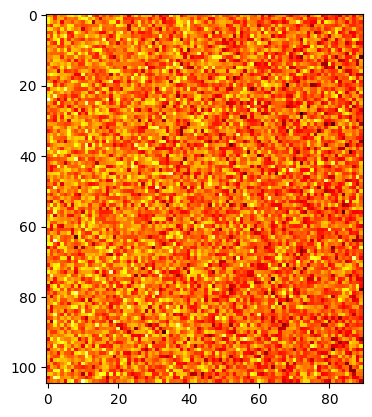

In [66]:
clean_pix_slice = (slice(385,490), slice(390,480))
clean_pixels = allframes[-4][clean_pix_slice]
plt.imshow(clean_pixels, cmap='hot')
plt.show()

# Mean Variance and Mean Counts

In [67]:

master_exp = zeros(9, dtype=float)

n_exps = zeros(9, dtype=int)

possible_exposures = []
for i,data in enumerate(allframes):
    exp_time = get_exp(frames[i])
    if exp_time not in possible_exposures:
        possible_exposures.append(exp_time)


    exp_idx = possible_exposures.index(exp_time)
    master_exp[exp_idx] += data
    n_exps[exp_idx] += 1

for i,mdata in enumerate(master_exp):
    mdata /= n_exps[i]

print(np.shape(master_exp))

(9, 1024, 1056)


In [68]:
def mean_variance(flat0, flat1):



    diff = (flat1-flat0).flatten()
    var = [d**2 for d in diff]
    return my_avg(var)

In [69]:
mean_counts = zeros(len(allframes), dtype=float)
mean_var = zeros(len(allframes), dtype=float)
for i,data in enumerate(allframes):
    exp_time = get_exp(frames[i])
    exp_idx = possible_exposures.index(exp_time)
    master = master_exp[exp_idx]
    cropped_data = data[clean_pix_slice]
    cropped_master = master[clean_pix_slice]
    mean_counts[i] = my_avg(cropped_data.flatten())
    mean_var[i] = mean_variance(cropped_master, cropped_data)

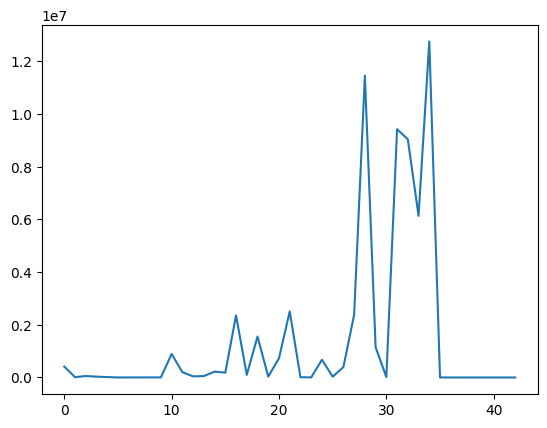

In [72]:
plt.plot(mean_var)
plt.show()